In [1]:

%cd ..

import pandas as pd
import numpy as np 
import glob
import matplotlib.pyplot as plt

import sys,os

import functions

import nelpy as nel  # main nelpy imports
import nelpy.plotting as npl  # optional plotting import

import math
import seaborn as sns
from tqdm import tqdm

import multiprocessing
from joblib import Parallel, delayed
import pickle

d:\github\ripple_heterogeneity\python


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [206]:
df = pd.read_csv(r'D:\projects\ripple_heterogeneity\df2.csv')
df

,Unnamed: 0,UID,acg_asymptote,acg_c,acg_d,acg_fit_rsquare,acg_h,acg_refrac,acg_tau_burst,acg_tau_decay,...,Cell_ID,Cell_Position,sessionID,spikeSortingID,FReach,nSpkEach,nCellsEvent,nSpkEvent,FRevent,ca1_layer
0,0,1,-1.532120,16.522713,5.931360,-0.012625,1.474277,2.682028,0.473957,13.450411,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,deep
1,1,2,-23.064667,26.643814,9.134459,0.113738,6.258009,5.664462,1.291070,306.662719,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sup
2,2,3,0.840493,15.088971,1.578631,0.037787,8.729285,9.382614,3.562163,3.965250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sup
3,3,4,-1.277228,5.261468,3.126066,0.156197,11.131308,1.859253,4.911992,48.220325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sup
4,4,5,0.742096,21.363206,1.627205,0.140852,14.854289,4.880360,2.242102,3.643337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sup
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58979,58979,45,2.908239,34.872689,1.477105,0.959025,22.021638,3.571092,0.716233,14.670906,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown
58980,58980,46,2.184381,10.943341,4.717377,0.764280,11.170513,1.418454,1.874889,11.942820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown
58981,58981,47,1.964000,51.411917,1.128616,0.322295,4.875674,5.747494,3.606801,5.961174,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown
58982,58982,48,2.658000,19.373333,3.683894,0.753586,9.850144,2.703619,0.654042,9.463668,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown


In [210]:
import warnings
warnings.filterwarnings("ignore")
def run_all(basepath,basename,save_path):
    '''
    run_all: loads data and runs analysis 
    '''

    cell_metrics,data = functions.load_cell_metrics(
                os.path.join(basepath,basename+'.cell_metrics.cellinfo.mat')
                )
    ripples = functions.load_ripples_events(
                os.path.join(basepath,basename+'.ripples.events.mat')
                )
                
    nChannels, fs, fs_dat, shank_to_channel = functions.loadXML(basepath)
    
    ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])

    st = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype="object"), fs=fs_dat)

    avg_fr_not_rip = st[~ripple_epochs].n_spikes / st[~ripple_epochs].support.duration
    avg_fr_in_rip = st[ripple_epochs].n_spikes / st[ripple_epochs].support.duration

    # ripple_gain = avg_fr_rip / avg_fr_not_rip
    ripple_gain = (avg_fr_in_rip - avg_fr_not_rip)  / (avg_fr_in_rip + avg_fr_not_rip)

    cell_metrics['ripple_gain'] = ripple_gain
    cell_metrics['avg_fr_in_rip'] = avg_fr_in_rip
    cell_metrics['avg_fr_not_rip'] = avg_fr_not_rip

    return cell_metrics

def main_loop(basepath,save_path):
    '''
    main_loop: file management 
    '''
    
    save_file = os.path.join(save_path,basepath.replace(os.sep, "_").replace(":", "_")  + '.pkl')
    
    # check if saved file exists
    if os.path.exists(save_file):
        return
    print(basepath)    
    # detect ripples and calc some features
    basename = os.path.basename(basepath)
    results = run_all(basepath,basename,save_path)   

    # save file
    with open(save_file, 'wb') as f:
        pickle.dump(results, f)

def ripple_gain_run(df,save_path,parallel=True):
    # find sessions to run
    basepaths = pd.unique(df.basepath)

    if parallel:
        num_cores = multiprocessing.cpu_count()         
        processed_list = Parallel(n_jobs=num_cores)(delayed(main_loop)(basepath,save_path) for basepath in basepaths)
    else:    
        for basepath in basepaths:
            # print(basepath)
            main_loop(basepath,save_path)

In [211]:
save_path = r"D:\projects\ripple_heterogeneity\ripple_gain"
ripple_gain_run(df,save_path,parallel=True)

# load results

In [236]:
def load_in_everything(save_path):
    
    sessions = glob.glob(save_path + os.sep + '*.pkl')
    
    results = pd.DataFrame()
    
    for session in sessions:
        with open(session, 'rb') as f:
            df1 = pickle.load(f)

        results = results.append(df1,ignore_index=True)
    return results

results = load_in_everything(save_path)
results

,UID,acg_asymptote,acg_c,acg_d,acg_fit_rsquare,acg_h,acg_refrac,acg_tau_burst,acg_tau_decay,acg_tau_rise,...,Cell_ID,Cell_Position,peakVoltage_expFitLengthConstant,spikeGroup,pulses_modulationIndex,pulses_modulationPeakResponseTime,pulses_modulationSignificanceLevel,SWR_modulationIndex,SWR_modulationPeakResponseTime,SWR_modulationSignificanceLevel
0,1,-1.532120,16.522713,5.931360,-0.012625,1.474277,2.682028,0.473957,13.450411,4.170582,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,-23.064667,26.643814,9.134459,0.113738,6.258009,5.664462,1.291070,306.662719,0.100385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0.840493,15.088971,1.578631,0.037787,8.729285,9.382614,3.562163,3.965250,3.790855,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,-1.277228,5.261468,3.126066,0.156197,11.131308,1.859253,4.911992,48.220325,10.082022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0.742096,21.363206,1.627205,0.140852,14.854289,4.880360,2.242102,3.643337,2.695966,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,2307,3.409633,30.378458,1.323144,0.927369,29.900269,3.484924,1.782731,9.636811,0.100004,...,NaN,NaN,1.621723,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16508,2311,2.768987,12.443300,3.019152,0.947330,51.983686,5.153668,0.768501,6.854900,0.687212,...,NaN,NaN,0.781136,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16509,2320,5.294099,12.083669,2.659163,0.650013,26.048121,5.677159,2.442887,2.425620,2.222017,...,NaN,NaN,2.519205,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16510,2330,4.940983,13.564665,2.192282,0.760124,11.669906,0.000193,2.215812,11.505927,5.308630,...,NaN,NaN,3.035612,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [237]:
# fix odd nested issues
brainRegion = []
for item in results.brainRegion:
    try:
        brainRegion.append(item[0])
    except:
        brainRegion.append('unknown')
results.brainRegion = brainRegion

results.putativeCellType = [item[0] for item in results.putativeCellType]

# lower case brain region and putativeCellType
results.brainRegion = results.brainRegion.str.lower()
results.loc[(results.brainRegion=="lca1") | (results.brainRegion=="rca1"),'brainRegion'] = "ca1"

results.putativeCellType = results.putativeCellType.str.lower()

results.animal = [item[0] for item in results.animal]

# make custom naming for kenji dataset
ids = ["ec012","ec013","ec014","ec016","f01_m",
      "g01_m","gor01","i01_m","j01_m","km01",
      "nlx"]

for id in ids:
    idx = (
            (results['basepath'].str.contains('Kenji')) &
            (results['basepath'].str.contains(id))
          )
    results.loc[idx,"animal"] = id

# add ca1 layer
results['ca1_layer'] = "unknown"
results.loc[df.CA1depth > 0,'ca1_layer'] = "deep"
results.loc[df.CA1depth == 0,'ca1_layer'] = "mid"
results.loc[df.CA1depth < 0,'ca1_layer'] = "sup"


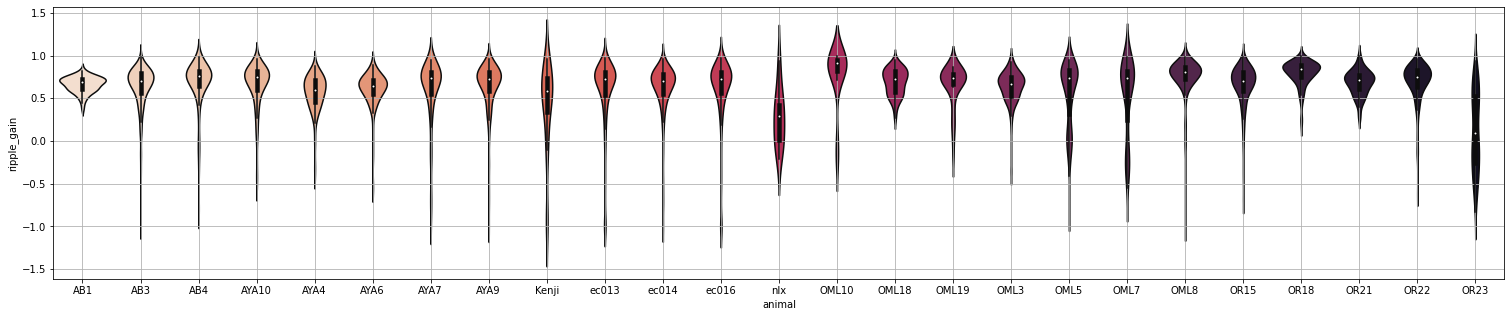

In [238]:
plt.figure(figsize=(26,5))

g = sns.violinplot(x="animal",
                    y="ripple_gain",
                    data=results[(results.putativeCellType=="pyramidal cell") & (results.brainRegion=="ca1")],
                    palette="rocket_r")
plt.grid('on')
# plt.ylim(0,1)

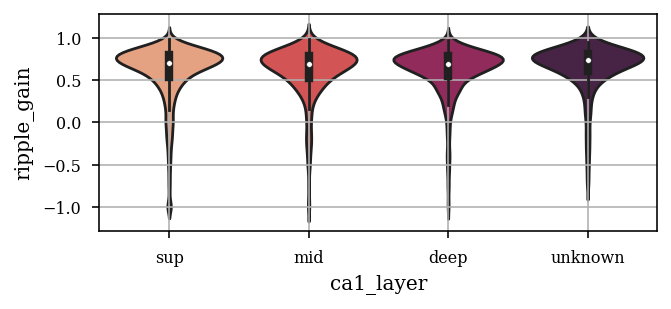

In [340]:
plt.figure(figsize=(5,2))

g = sns.violinplot(x="ca1_layer",
                    y="ripple_gain",
                    data=results[(results.putativeCellType=="pyramidal cell") & (results.brainRegion=="ca1")],
                    palette="rocket_r")
plt.grid('on')

In [285]:
tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "svg.fonttype": 'none'
}
plt.style.use('seaborn-paper')
plt.rcParams.update(tex_fonts)

%config InlineBackend.figure_format = 'retina'

In [357]:
from sklearn.linear_model import RANSACRegressor,LinearRegression
from matplotlib.ticker import AutoMinorLocator

def get_slope_intercept(X,y):
    # remove infs and nans
    idx = np.isinf(X) | np.isinf(y) | np.isnan(X) | np.isnan(y) 

    X = np.array(X)
    y = np.array(y)

    X = X[~(idx)]
    y = y[~(idx)]
    # reg = LinearRegression().fit(X.reshape(-1, 1),y.reshape(-1, 1))
    reg = RANSACRegressor().fit(X.reshape(-1, 1),y.reshape(-1, 1))
    xaxis = np.arange(X.min(), X.max(), 0.01)
    yaxis = reg.predict(xaxis.reshape((len(xaxis), 1)))
    r2 = reg.score(X.reshape(-1, 1),y.reshape(-1, 1))
    return xaxis,yaxis,r2,reg

def plot_feature(feature_1, feature_2,results,cell_type,ax,color='k',alpha=.5,linewidth=1):
    idx = results.putativeCellType == cell_type
    X = results[feature_1][idx]
    y = results[feature_2][idx]
    idx = np.isinf(X) | np.isinf(y) | np.isnan(X) | np.isnan(y) 
    X = np.array(X)
    y = np.array(y)
    X = X[~(idx)]
    y = y[~(idx)]
    ax.scatter(X,y,s=1,alpha=alpha,color=color,rasterized=True)
    xaxis,yaxis,r2,reg = get_slope_intercept(X,y)
    ax.plot(xaxis,yaxis,linewidth=linewidth,color=color,label=('R2='+str(round(r2, 2))))                                      

Text(0.5, 1.0, 'unknown')

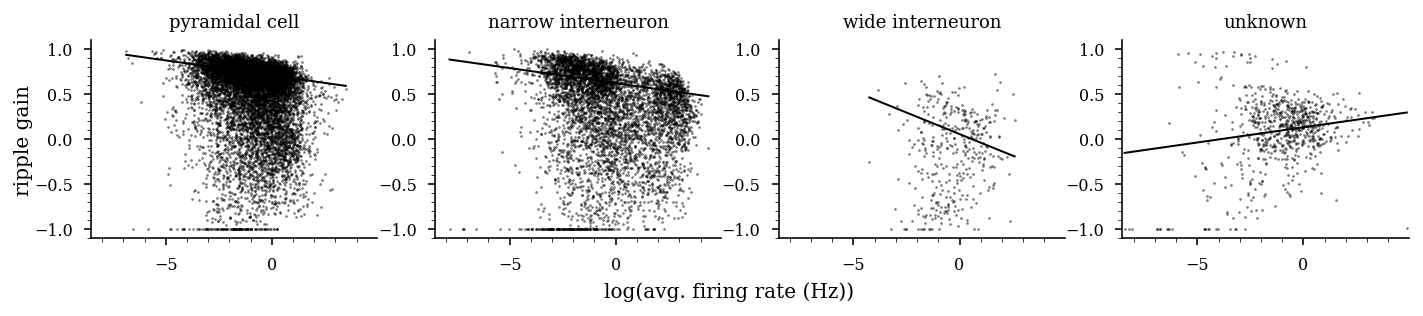

In [358]:
fig, axs = plt.subplots(1,4, figsize=functions.set_size('thesis', fraction=2, subplots=(1, 4)), edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.2)
ax = axs.ravel()

plot_feature('avg_fr_not_rip_log', 'ripple_gain',results,'pyramidal cell',ax[0],color='k')
plot_feature('avg_fr_not_rip_log', 'ripple_gain',results,'narrow interneuron',ax[1],color='k')
plot_feature('avg_fr_not_rip_log', 'ripple_gain',results,'wide interneuron',ax[2],color='k')
plot_feature('avg_fr_not_rip_log', 'ripple_gain',results,'unknown',axs[3],color='k')

fig.text(0.5,-0.1, 'log(avg. firing rate (Hz))', ha='center')
fig.text(0.08, 0.5, 'ripple gain', va='center', rotation='vertical')

x = results.avg_fr_not_rip_log
x_min = min(x[(np.isinf(x) | np.isnan(x))==False])-.1
x_max = max(x[(np.isinf(x) | np.isnan(x))==False])+.1

for i in range(4):
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_ylim(-1.1,1.1)
    ax[i].set_xlim(x_min,x_max)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator())
    ax[i].yaxis.set_minor_locator(AutoMinorLocator())

ax[0].set_title('pyramidal cell',fontsize=9)
ax[1].set_title('narrow interneuron',fontsize=9)
ax[2].set_title('wide interneuron',fontsize=9)
ax[3].set_title('unknown',fontsize=9)

Text(0.5, 1.0, 'wide interneuron')

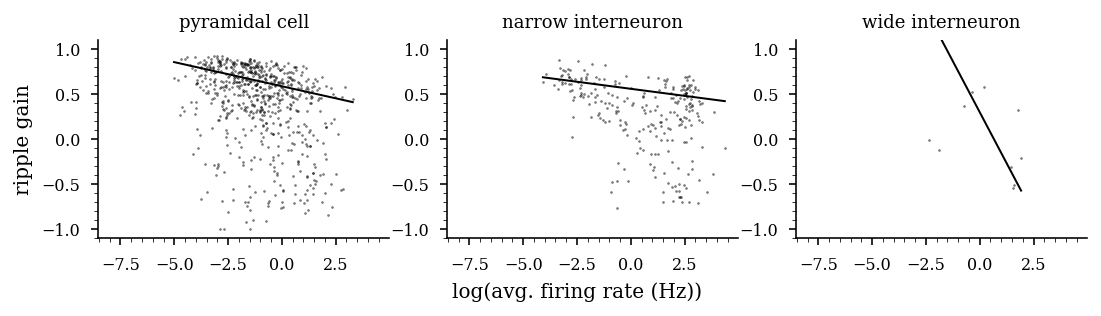

In [359]:
fig, axs = plt.subplots(1,3, figsize=functions.set_size('thesis', fraction=1.5, subplots=(1, 3)), edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.2)
ax = axs.ravel()

idx = results.brainRegion == "dg"
plot_feature('avg_fr_not_rip_log', 'ripple_gain',results[idx],'pyramidal cell',ax[0],color='k')
plot_feature('avg_fr_not_rip_log', 'ripple_gain',results[idx],'narrow interneuron',ax[1],color='k')
plot_feature('avg_fr_not_rip_log', 'ripple_gain',results[idx],'wide interneuron',ax[2],color='k')

fig.text(0.5,-0.1, 'log(avg. firing rate (Hz))', ha='center')
ax[0].set_ylabel('ripple gain')

x = results.avg_fr_not_rip_log
x_min = min(x[(np.isinf(x) | np.isnan(x))==False])-.1
x_max = max(x[(np.isinf(x) | np.isnan(x))==False])+.1

for i in range(3):
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_ylim(-1.1,1.1)
    ax[i].set_xlim(x_min,x_max)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator())
    ax[i].yaxis.set_minor_locator(AutoMinorLocator())

ax[0].set_title('pyramidal cell',fontsize=9)
ax[1].set_title('narrow interneuron',fontsize=9)
ax[2].set_title('wide interneuron',fontsize=9)


Text(0.5, 1.0, 'wide interneuron')

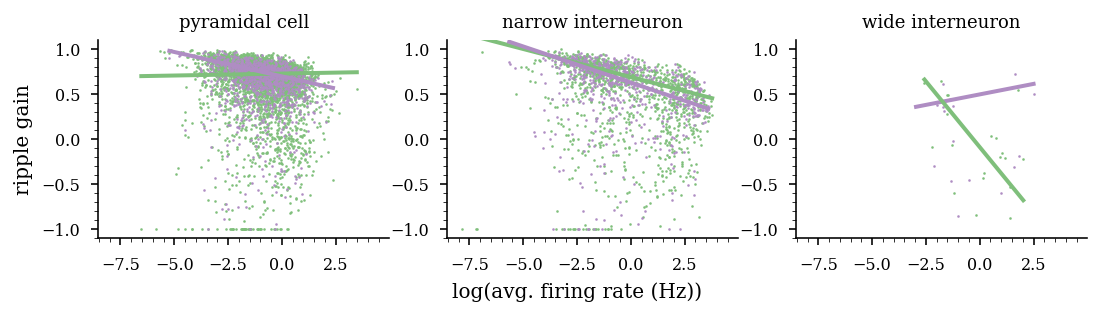

In [362]:
fig, axs = plt.subplots(1,3, figsize=functions.set_size('thesis', fraction=1.5, subplots=(1, 3)), edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.2)
ax = axs.ravel()

idx = results.brainRegion == "ca1"

plot_feature('avg_fr_not_rip_log','ripple_gain', results[idx & (df.ca1_layer=="sup")],'pyramidal cell',ax[0],color='#7fbf7b',alpha=1,linewidth=2)
plot_feature('avg_fr_not_rip_log','ripple_gain', results[idx & (df.ca1_layer=="deep")],'pyramidal cell',ax[0],color='#af8dc3',alpha=1,linewidth=2)

plot_feature('avg_fr_not_rip_log','ripple_gain', results[idx & (df.ca1_layer=="sup")],'narrow interneuron',ax[1],color='#7fbf7b',alpha=1,linewidth=2)
plot_feature('avg_fr_not_rip_log','ripple_gain', results[idx & (df.ca1_layer=="deep")],'narrow interneuron',ax[1],color='#af8dc3',alpha=1,linewidth=2)

plot_feature('avg_fr_not_rip_log','ripple_gain', results[idx & (df.ca1_layer=="deep")],'wide interneuron',ax[2],color='#af8dc3',alpha=1,linewidth=2)
plot_feature('avg_fr_not_rip_log','ripple_gain', results[idx & (df.ca1_layer=="sup")],'wide interneuron',ax[2],color='#7fbf7b',alpha=1,linewidth=2)

fig.text(0.5,-0.1, 'log(avg. firing rate (Hz))', ha='center')
ax[0].set_ylabel('ripple gain')

x = results.avg_fr_not_rip_log
x_min = min(x[(np.isinf(x) | np.isnan(x))==False])-.1
x_max = max(x[(np.isinf(x) | np.isnan(x))==False])+.1

for i in range(3):
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_ylim(-1.1,1.1)
    ax[i].set_xlim(x_min,x_max)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator())
    ax[i].yaxis.set_minor_locator(AutoMinorLocator())

ax[0].set_title('pyramidal cell',fontsize=9)
ax[1].set_title('narrow interneuron',fontsize=9)
ax[2].set_title('wide interneuron',fontsize=9)

# single session example below

In [17]:
basepath = df.basepath[0]
basename = df.basename[0]

cell_metrics,data = functions.load_cell_metrics(
            os.path.join(basepath,basename+'.cell_metrics.cellinfo.mat')
            )
ripples = functions.load_ripples_events(
    os.path.join(basepath,basename+'.ripples.events.mat')
    )

cell_metrics.putativeCellType = [item[0] for item in cell_metrics.putativeCellType]


In [29]:
nChannels, fs, fs_dat, shank_to_channel = functions.loadXML(basepath)
ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])


In [27]:
# st = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype="object"), support=epochs, fs=fs_dat)
st = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype="object"), fs=fs_dat)

st

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


<SpikeTrainArray at 0x1f00bf5a1c0: 105 units> at 20000 Hz

In [63]:
avg_fr = st.n_spikes / st.support.duration
avg_fr_not_rip = st[~ripple_epochs].n_spikes / st[~ripple_epochs].support.duration
avg_fr_rip = st[ripple_epochs].n_spikes / st[ripple_epochs].support.duration

# ripple_gain = avg_fr_rip / avg_fr_not_rip
ripple_gain = (avg_fr_rip - avg_fr_not_rip)  / (avg_fr_rip + avg_fr_not_rip)



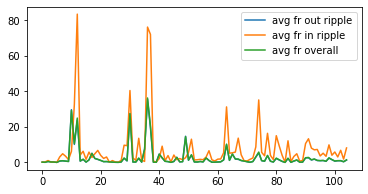

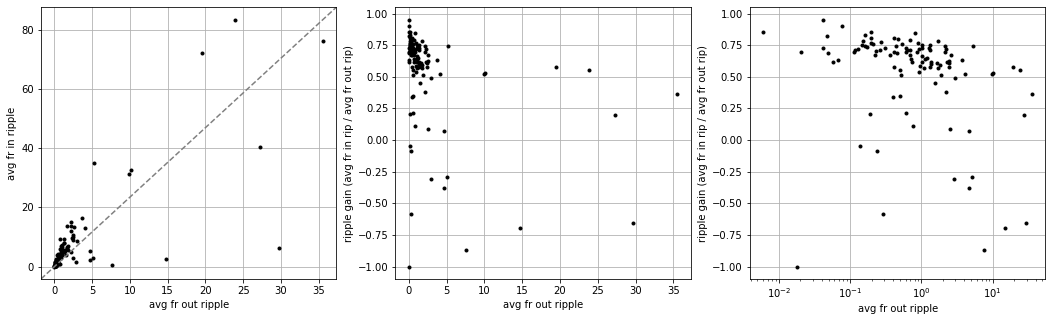

In [72]:
f, ax = plt.subplots(figsize=(6, 3))
ax.plot(avg_fr_not_rip,label='avg fr out ripple')
ax.plot(avg_fr_rip,label='avg fr in ripple')
ax.plot(avg_fr,label='avg fr overall')
ax.legend()

# f, ax = plt.subplots(figsize=(6, 6))
# ax.plot(avg_fr_not_rip,avg_fr_rip,'.k')
# ax.plot([0, 1], [0, 1], transform=ax.transAxes,ls='--',color='grey')
# ax.set_xlabel('avg fr out ripple')
# ax.set_ylabel('avg fr in ripple')
# ax.grid()

f, ax = plt.subplots(1,3,figsize=(18, 5))


ax[0].plot(avg_fr_not_rip,avg_fr_rip,'.k')
ax[0].plot([0, 1], [0, 1], transform=ax[0].transAxes,ls='--',color='grey')
ax[0].set_xlabel('avg fr out ripple')
ax[0].set_ylabel('avg fr in ripple')
ax[0].grid()


ax[1].plot(avg_fr_not_rip,ripple_gain,'.k')
ax[1].set_xlabel('avg fr out ripple')
ax[1].set_ylabel('ripple gain (avg fr in rip / avg fr out rip)')
ax[1].grid()

ax[2].plot(avg_fr_not_rip,ripple_gain,'.k')
ax[2].set_xscale('log')
ax[2].set_xlabel('avg fr out ripple')
ax[2].set_ylabel('ripple gain (avg fr in rip / avg fr out rip)')
ax[2].grid()


# f, ax = plt.subplots(figsize=(6, 6))
# ax.plot(avg_fr,avg_fr_not_rip,'.k')
# ax.plot([0, 1], [0, 1], transform=ax.transAxes,ls='--',color='grey')
# ax.set_xlabel('avg fr')
# ax.set_ylabel('avg fr out ripple')
# ax.grid()

In [84]:
cell_metrics.putativeCellType = [item[0] for item in cell_metrics.putativeCellType]
cell_metrics.putativeCellType



0      Narrow interneuron
1          Pyramidal Cell
2      Narrow interneuron
3      Narrow interneuron
4      Narrow interneuron
              ...        
100        Pyramidal Cell
101        Pyramidal Cell
102        Pyramidal Cell
103        Pyramidal Cell
104        Pyramidal Cell
Name: putativeCellType, Length: 105, dtype: object

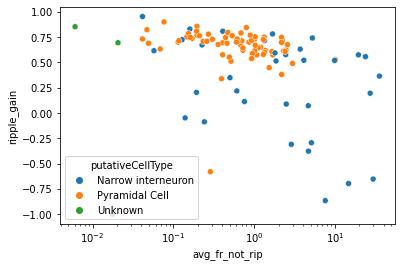

In [93]:
cell_metrics['ripple_gain'] = ripple_gain
cell_metrics['avg_fr_not_rip'] = avg_fr_not_rip

sns.scatterplot(x="avg_fr_not_rip", y="ripple_gain",hue="putativeCellType",data=cell_metrics)
plt.xscale("log")
